In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast#, RandomBrightness
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#print("Device:", tpu.master())


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [4]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#getting dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
#checking train and test size
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


# Data Preprocessing

In [7]:
#use train_test_split to create validation set.
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=10
                                                                              ,shuffle=True)

In [8]:
#looking at train, validation and test set shapes
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [9]:
#scaling done in the model
#scaling the train, validation and test sets by 255. Equivelant to min_max scaling

#x_train_norm = x_train_split/255
#x_valid_norm = x_valid_split/255
#x_test_norm = x_test/255

# Helpful Model Fitting and Results Functions

In [10]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [11]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer='adam',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=512,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
        
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }')
                                                                       

    return history, model

In [12]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [13]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [14]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [15]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                     #index = [0,1,2,3,4,5,6,7,8,9], 
                     #columns = [0,1,2,3,4,5,6,7,8,9]
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 6 - Hyperparameter Tuning with CNN architecture and Data Augmentation

In [16]:
#Data augmentation model which will serve as a layer in the hyperparameter tuned model below
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal", input_shape=(32,32,3)))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomZoom(0.2))
data_augmentation.add(RandomContrast(0.2))

In [17]:
#Experiment 6 model
def create_model_exp_6(hp):
    
    model=Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(data_augmentation)
    model.add(Rescaling(1./255))
    #tunning for a choice of 2 or 3 Convolutional layers
    for i in range(hp.Int("Number_Conv_layers",2,3)):
        #within each layer testing for a min of 128 filters, a max of 512 filters and any in between by 
        #multiples of 128. Also testing kernel sized 3, 4, 5. 
        model.add(Conv2D(filters=hp.Int("Conv_Filters_{}".format(i), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i), 3, 5),
                        padding='same',
                        activation='relu'))
        #testing strides of 1 or 2 for max pooling
        model.add(MaxPool2D(pool_size=(2,2), 
                  strides=hp.Int("Max_Pool_strides_{}".format(i), 1,2     )))
        #testing for dropout of values 0.1 to 0.40  by increments of 0.10 after every MaxPool layer
        model.add(Dropout (hp.Float("Conv_Dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Flatten())
    #testing for number of nodes from 128 to 512 by multiples of 128 for the dense layer
    model.add(Dense(units=hp.Int("Dense_nodes", min_value=128, max_value=512, step=128), activation="relu"))
    model.add(BatchNormalization())
    #testing for dropout of values 0.10 to 0.40 by increments of 0.10 for Dense Layer
    model.add(Dropout (hp.Float("Dropout_Dense_{}", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(10, activation = "softmax"))
    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

create_model_exp_6(kt.HyperParameters())

In [18]:

#creating Bayesian Optimization for KerasTuner
tuner_exp_6 = kt.BayesianOptimization(
    hypermodel=create_model_exp_6,
    objective="val_accuracy",
    max_trials=20,
    overwrite=True,
    
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_2/keras_tuner_out',
    project_name="exp_6")

In [19]:
#setting epochs, patience and early stopping
epochs=100
patience=3
model_number="6"
early_stopping= EarlyStopping(patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_6.search(x_train_split, y_train_split, epochs=epochs, batch_size=512, validation_data=(x_valid_split, y_valid_split), callbacks= [early_stopping])


Trial 20 Complete [00h 04m 49s]
val_accuracy: 0.7832000255584717

Best val_accuracy So Far: 0.7868000268936157
Total elapsed time: 00h 40m 15s
INFO:tensorflow:Oracle triggered exit


In [20]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_6=tuner_exp_6.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_Conv(bhp):
    num_conv_layers=bhp.get('Number_Conv_layers')
    print("Number of layers: {}".format(num_conv_layers))
    print("\n")
    for i in range(0,num_conv_layers):
        print("Number of filters in Conv_Layer_{}:".format(i), bhp.get("Conv_Filters_{}".format(i)))
        print("Kernel size for Conv Layer_{}:".format(i), bhp.get("Conv_kernel_size_{}".format(i)))
        print("Strides for Max Pooling Layer_{}:".format(i), bhp.get("Max_Pool_strides_{}".format(i)))
        print("Dropout in Conv layer_{}:".format(i), bhp.get("Conv_Dropout_{}".format(i)))
        print("\n")
    print('Number of nodes in Dense Layer:', bhp.get('Dense_nodes'))
    print('Dropout in Dense Layer:', bhp.get('Dropout_Dense_{}'))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_Conv(best_hyper_parameters_exp_6)  

Number of layers: 3


Number of filters in Conv_Layer_0: 128
Kernel size for Conv Layer_0: 3
Strides for Max Pooling Layer_0: 2
Dropout in Conv layer_0: 0.1


Number of filters in Conv_Layer_1: 512
Kernel size for Conv Layer_1: 5
Strides for Max Pooling Layer_1: 1
Dropout in Conv layer_1: 0.4


Number of filters in Conv_Layer_2: 256
Kernel size for Conv Layer_2: 5
Strides for Max Pooling Layer_2: 1
Dropout in Conv layer_2: 0.1


Number of nodes in Dense Layer: 512
Dropout in Dense Layer: 0.4


Optimizer Used: adam


In [21]:
#getting paremeters of best model
model_exp_6_best_params = tuner_exp_6.get_best_hyperparameters(2)
# Building model exp_6 with best hyper parameters

model_exp_6_best = create_model_exp_6(model_exp_6_best_params[0])

In [22]:
model_exp_6_best.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 512)       1638912   
                                                      

In [23]:
# Running best model 6 to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=100
patience=3
model_number="6"
history_exp_6_best, model_exp_6_best = compile_train_model(model_exp_6_best,
                                     x_train_split, y_train_split,
                                     x_valid_split, y_valid_split, model_number, epochs
                                    )

Epoch 1/100
88/88 [==============================] - 9s 87ms/step - loss: 1.9258 - accuracy: 0.3188 - val_loss: 2.9828 - val_accuracy: 0.2348
Epoch 2/100
88/88 [==============================] - 7s 83ms/step - loss: 1.5331 - accuracy: 0.4488 - val_loss: 1.7376 - val_accuracy: 0.3740
Epoch 3/100
88/88 [==============================] - 7s 83ms/step - loss: 1.3557 - accuracy: 0.5171 - val_loss: 1.2888 - val_accuracy: 0.5432
Epoch 4/100
88/88 [==============================] - 7s 83ms/step - loss: 1.2169 - accuracy: 0.5670 - val_loss: 1.3068 - val_accuracy: 0.5452
Epoch 5/100
88/88 [==============================] - 7s 83ms/step - loss: 1.1235 - accuracy: 0.6026 - val_loss: 1.1019 - val_accuracy: 0.6202
Epoch 6/100
88/88 [==============================] - 7s 83ms/step - loss: 1.0438 - accuracy: 0.6326 - val_loss: 1.8494 - val_accuracy: 0.4664
Epoch 7/100
88/88 [==============================] - 7s 83ms/step - loss: 1.0008 - accuracy: 0.6480 - val_loss: 1.0463 - val_accuracy: 0.6386
Epoch 

In [24]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_6_best, model_number, epochs, patience=patience)

Model Experiment 6  Training Loss:  0.6366
Model Experiment 6  Training Accuracy:  0.7771
Model Experiment 6  Validation Loss:  0.6172
Model Experiment 6  Validation Accuracy: 0.7922


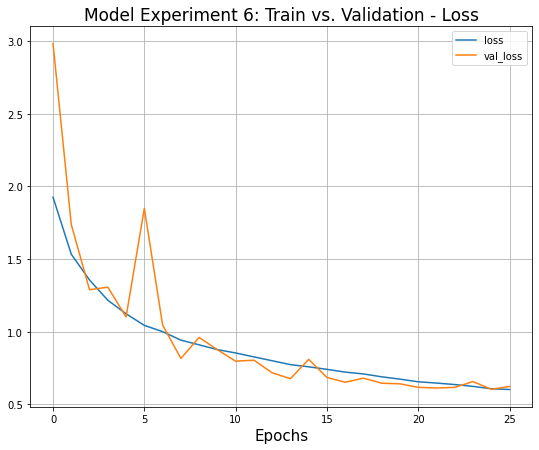

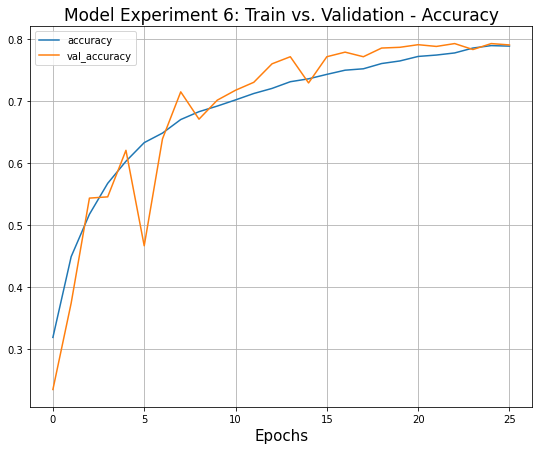

In [25]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_6_best, model_number)

In [26]:
#creating  classification report

#getting predictions

model_exp_6_best_predictions=model_exp_6_best.predict(x_test).argmax(axis=1)
print_validation_report(y_test, model_exp_6_best_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1000
           1       0.89      0.91      0.90      1000
           2       0.77      0.69      0.73      1000
           3       0.76      0.48      0.59      1000
           4       0.80      0.75      0.77      1000
           5       0.71      0.74      0.73      1000
           6       0.71      0.92      0.80      1000
           7       0.87      0.81      0.84      1000
           8       0.92      0.85      0.88      1000
           9       0.76      0.90      0.82      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Accuracy Score: 0.7921
Root Mean Square Error: 1.9406442229321683


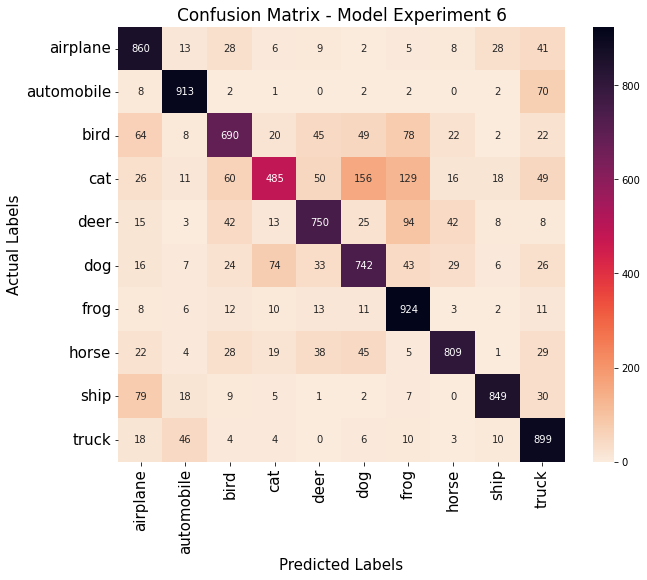

In [27]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_6_best, x_test, y_test, model_number)